# NCAA ML Competition - Women's 2018
## W207 Final Project
## Julia Buffinton, Charlene Chen, Arvindh Ganesan, Prashant Kumar Sahay
### Due: 4/17/18

## Import Relevant Libraries

In [12]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

## Load regular season data

First we load the datasets that were provided from Kaggle. We did construct a `WLeagues.csv` file based on information from NCAA regarding to which leagues the teams below. Also, the `df_tour_18` file includes the games that were actually played in the NCAA tournament, which we will use for evaluation at the end. 

In [4]:
# Load the data
data_dir = './WStage2DataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour_compact = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_tour_detail = pd.read_csv(data_dir + 'WNCAATourneyDetailedResults.csv')
df_reg_compact = pd.read_csv(data_dir + 'WRegularSeasonCompactResults.csv')
df_reg_detail = pd.read_csv(data_dir + 'WRegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(data_dir + 'WTeams.csv')
df_teams_leagues = pd.merge(left=df_teams, right=pd.read_csv(data_dir + 'WLeagues.csv'), how='left', on=['TeamName'])
df_tour_18 = pd.read_csv('NCAA_Result_2018_sep.csv')

## Get just numeric seeds - we aren't interested in region

We believe that the region to which a team belongs is not informative of their standings (Seed 7 in the East Region is not inherently different from Seed 7 in the South) so we strip that information and move forward with only the numerical seed information.


In [5]:
# get just integer value of seed (exclude region information)
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['SeedInt'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

## Load the league that each team belongs to

In [6]:
df_winning_team_leagues = df_teams_leagues.rename(columns={'TeamID' : 'WTeamID', 'LeagueName' : 'WLeagueName'}).drop('TeamName',1)
df_winning_team_leagues.head()

,WTeamID,WLeagueName
0,3101,Southland
1,3102,MWC
2,3103,MAC
3,3104,SEC
4,3105,SWAC


## Load and bin league performance (to dampen the effect of small variations)

We gather league performance information (based on the performance of teams from that league in the NCAA tournament) and bin the values to dampen the effect of small variation.  We combine this with each team to represent the performance of the league they're in. This information can be used in conjunction with regular season field performance stats to indciate enhance our understanding of a team's performance.

In [62]:
## Bin league performance into 10 bins
df_league_perf = pd.read_pickle('league_performance')

df_league_perf_eda = df_league_perf
df_league_perf['Leaguebin'] = pd.cut(df_league_perf['PctWins mean'], 24, labels=False)

df_league_perf = df_league_perf[['LeagueName', 'Leaguebin']]
df_team_league_perf = pd.merge(left=df_teams_leagues, right=df_league_perf, how='left', on=['LeagueName'])

df_team_league_perf = df_team_league_perf[['TeamID', 'Leaguebin']]
df_league_perf_eda.head()

,LeagueName,PctWins mean,PctWins count,Leaguebin
0,AAC,0.244191,12,9
1,ACC,0.546656,14,22
2,ASUN,0.050000,4,2
3,America East,0.168571,5,6
4,Atlantic 10,0.266138,9,10


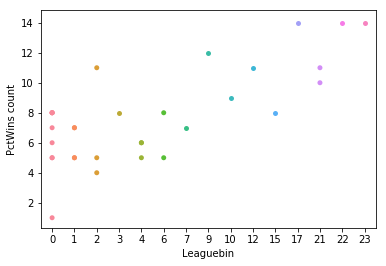

In [63]:
# League performance in terms of Tournament win count
sns.stripplot(x="Leaguebin", y="PctWins count", data=df_league_perf_eda);

It appears that the certain leagues (the one with higher order bins) have higher tournament percentage win. This may be crucial data that will inform us on the underlying team strengths.

In [8]:
## Inject winning and losing teams' leaugues into df
# Total of 36 columns
df_reg_detail = pd.merge(left=df_reg_detail, right=df_winning_team_leagues, how='left', on=['WTeamID'])

df_losing_team_leagues = df_winning_team_leagues.rename(columns={'WTeamID': 'LTeamID', 'WLeagueName': 'LLeagueName'})
df_reg_detail = pd.merge(left=df_reg_detail, right=df_losing_team_leagues, how='left', on=['LTeamID'])
df_reg_detail.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WLeagueName,LLeagueName
0,2010,11,3103,63,3237,49,H,0,23,54,...,10,11,27,11,23,7,6,19,MAC,Horizon
1,2010,11,3104,73,3399,68,N,0,26,62,...,27,14,26,7,20,4,2,27,SEC,OVC
2,2010,11,3110,71,3224,59,A,0,29,62,...,23,17,23,8,15,6,0,15,Patriot,MEAC
3,2010,11,3111,63,3267,58,A,0,27,52,...,25,22,22,15,11,14,5,14,Sun Belt,C-USA
4,2010,11,3119,74,3447,70,H,1,30,74,...,21,21,32,12,14,4,2,14,Patriot,NEC


## EDA

# Indicators of Regular Season Success

Let’s now turn to the regular season game statistics. We are interested in knowing how certain statistics correlate with winning vs losing. We will take the regular season detail and first convert it to a more ‘long’ format with only 1 column of TeamIDs and a factor indicating whether that row corresponds to a win or a loss. Here I also add some additional game statistcs. These include field goal percentage, free throw percentage, offensive/defensive rebounding efficiency, and possessions. 

In [9]:
# Let's create a seperate dataset for  EDA
df_reg_detail_eda = df_reg_detail
# Calculate additional metrics for the winning team

# Calculate Field Goal Percentage 

df_reg_detail_eda['WFGP'] = df_reg_detail_eda.WFGM / df_reg_detail_eda.WFGA

# Calculate 2Pt Field Goal Percentage

df_reg_detail_eda['WFGP2'] = (df_reg_detail_eda.WFGM - df_reg_detail_eda.WFGM3) / (df_reg_detail_eda.WFGA - df_reg_detail_eda.WFGA3)

# Calculate 3Pt Field Goal Percentage

df_reg_detail_eda['WFGP3'] = df_reg_detail_eda.WFGM3 / df_reg_detail_eda.WFGA3

# Calculate Free Throw Shooting

df_reg_detail_eda['WFTP'] = df_reg_detail_eda.WFTM / df_reg_detail_eda.WFTA

# Calculate Offensive Rebounding Efficiency

df_reg_detail_eda['WORP'] = df_reg_detail_eda.WOR / (df_reg_detail_eda.WOR + df_reg_detail_eda.LDR)

# Calculate Defensive Rebounding Efficiency

df_reg_detail_eda['WDRP'] = df_reg_detail_eda.WDR / (df_reg_detail_eda.WDR + df_reg_detail_eda.LOR)

# Calculate Possessions

df_reg_detail_eda['WPOS'] = 0.96 * (df_reg_detail_eda.WFGA + df_reg_detail_eda.WTO + 0.44 * df_reg_detail_eda.WFTA - df_reg_detail_eda.WOR)

# Calculate additional metrics for the Losing team

# Calculate Field Goal Percentage 

df_reg_detail_eda['LFGP'] = df_reg_detail_eda.LFGM / df_reg_detail_eda.LFGA

# Calculate 2Pt Field Goal Percentage

df_reg_detail_eda['LFGP2'] = (df_reg_detail_eda.LFGM - df_reg_detail_eda.LFGM3) / (df_reg_detail_eda.LFGA - df_reg_detail_eda.LFGA3)

# Calculate 3Pt Field Goal Percentage

df_reg_detail_eda['LFGP3'] = df_reg_detail_eda.LFGM3 / df_reg_detail_eda.LFGA3

# Calculate Free Throw Shooting

df_reg_detail_eda['LFTP'] = df_reg_detail_eda.LFTM / df_reg_detail_eda.LFTA

# Calculate Offensive Rebounding Efficiency

df_reg_detail_eda['LORP'] = df_reg_detail_eda.LOR / (df_reg_detail_eda.LOR + df_reg_detail_eda.LDR)

# Calculate Defensive Rebounding Efficiency

df_reg_detail_eda['LDRP'] = df_reg_detail_eda.LDR / (df_reg_detail_eda.LDR + df_reg_detail_eda.LOR)

# Calculate Possessions

df_reg_detail_eda['LPOS'] = 0.96 * (df_reg_detail_eda.LFGA + df_reg_detail_eda.LTO + 0.44 * df_reg_detail_eda.LFTA - df_reg_detail_eda.LOR)

In [10]:
# Get the list of all winning team features

Win_Features = list(filter(None,[a if a[0]== 'W' else None for a in df_reg_detail_eda.columns.values]))

# Get the list of all losing team features

Loss_Features = list(filter(None,[a if a[0]== 'L' else None for a in df_reg_detail_eda.columns.values]))

# Add the winning team location - This feature will be transformed at a later point to provide the perspective of the losing team

Loss_Features.insert(2,'WLoc')

# Get the list of generic features for both the winning and the losing team

Consolidated_Features = list(map(lambda x : x[1:],Win_Features))

# Extract the winning team information from the regular season detail

df_reg_detail_eda_winners = df_reg_detail_eda.loc[:,Win_Features].rename(columns = dict(zip(Win_Features,Consolidated_Features))).reset_index()

#  Set the outcome variable to 'W' to denote a win

df_reg_detail_eda_winners['Outcome'] = 'W'

# Extract the losing team information from the regular season detail

df_reg_detail_eda_losers =  df_reg_detail_eda.loc[:,Loss_Features].rename(columns = dict(zip(Loss_Features,Consolidated_Features))).reset_index()

#  Set the outcome variable to 'L' to denote a loss

df_reg_detail_eda_losers['Outcome'] = 'L'

# Concatenate the winning features and the losing features

df_reg_detail_eda_winners_losers = df_reg_detail_eda_winners.iloc[0:df_reg_detail_eda_winners.shape[0]-1].append(df_reg_detail_eda_losers.iloc[0:df_reg_detail_eda_losers.shape[0]-1]).reset_index()

/Users/arganesa/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/arganesa/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


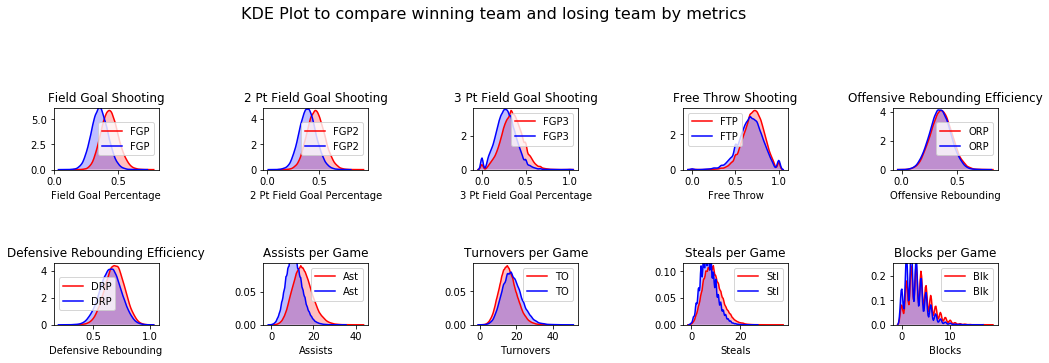

In [14]:
# Plot kernal density plots for the various metrics to show the metrics distribution when winning and losing.

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.0, hspace=1.5)
fig.set_size_inches(15, 5, forward=True)


g1 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='W'].FGP, shade=True, color="r",ax=ax[0,0],legend=True)

g2 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='L'].FGP, shade=True, color="b",ax=ax[0,0],legend=True)


ax[0,0].set_title('Field Goal Shooting')
ax[0,0].set_xlabel('Field Goal Percentage')

g1 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='W'].FGP2, shade=True, color="r",ax=ax[0,1],legend=True)

g2 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='L'].FGP2, shade=True, color="b",ax=ax[0,1],legend=True)

ax[0,1].set_title('2 Pt Field Goal Shooting')
ax[0,1].set_xlabel('2 Pt Field Goal Percentage')

g1 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='W'].FGP3, shade=True, color="r",ax=ax[0,2],legend=True)

g2 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='L'].FGP3, shade=True, color="b",ax=ax[0,2],legend=True)

ax[0,2].set_title('3 Pt Field Goal Shooting')
ax[0,2].set_xlabel('3 Pt Field Goal Percentage')

g1 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='W'].FTP, shade=True, color="r",ax=ax[0,3],legend=True)

g2 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='L'].FTP, shade=True, color="b",ax=ax[0,3],legend=True)

ax[0,3].set_title('Free Throw Shooting')
ax[0,3].set_xlabel('Free Throw')


g1 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='W'].ORP, shade=True, color="r",ax=ax[0,4],legend=True)

g2 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='L'].ORP, shade=True, color="b",ax=ax[0,4],legend=True)
ax[0,4].set_title('Offensive Rebounding Efficiency')
ax[0,4].set_xlabel('Offensive Rebounding')


g1 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='W'].DRP, shade=True, color="r",ax=ax[1,0],legend=True)

g2 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='L'].DRP, shade=True, color="b",ax=ax[1,0],legend=True)
ax[1,0].set_title('Defensive Rebounding Efficiency')

ax[1,0].set_xlabel('Defensive Rebounding')

g1 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='W'].Ast, shade=True, color="r",ax=ax[1,1],legend=True)

g2 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='L'].Ast, shade=True, color="b",ax=ax[1,1],legend=True)

ax[1,1].set_title('Assists per Game')
ax[1,1].set_xlabel('Assists')

g1 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='W'].TO, shade=True, color="r",ax=ax[1,2],legend=True)

g2 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='L'].TO, shade=True, color="b",ax=ax[1,2],legend=True)

ax[1,2].set_title('Turnovers per Game')
ax[1,2].set_xlabel('Turnovers')

g1 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='W'].Stl, shade=True, color="r",ax=ax[1,3],legend=True)

g2 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='L'].Stl, shade=True, color="b",ax=ax[1,3],legend=True)

ax[1,3].set_title('Steals per Game')
ax[1,3].set_xlabel('Steals')

g1 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='W'].Blk, shade=True, color="r",ax=ax[1,4],legend=True)

g2 = sns.kdeplot(df_reg_detail_eda_winners_losers.loc[df_reg_detail_eda_winners_losers.Outcome=='L'].Blk, shade=True, color="b",ax=ax[1,4],legend=True)

ax[1,4].set_title('Blocks per Game')
ax[1,4].set_xlabel('Blocks')

fig.suptitle("KDE Plot to compare winning team and losing team by metrics", size=16)
fig.subplots_adjust(top=0.7)
fig.legend()

On an average, Field Goal Percentage, 2Pt Field Goal Percentage, 3Pt Field Goal Percentage and Assists per game made the telling difference between winning and losing. 

### Explore the impact of relative team performance on game outcome

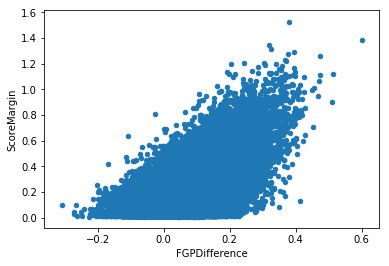

In [57]:
df_reg_detail_eda['WFGP'] = df_reg_detail_eda.WFGM / df_reg_detail_eda.WFGA ## Field goal percentage for the winning team
df_reg_detail_eda['LFGP'] = df_reg_detail_eda.LFGM / df_reg_detail_eda.LFGA ## Field goal percentage for the losing team
df_reg_detail_eda['FGPDifference'] = (df_reg_detail_eda.WFGP - df_reg_detail_eda.LFGP) ## Difference in field goal percentage
df_reg_detail_eda['ScoreMargin'] = 2 * (df_reg_detail_eda.WScore - df_reg_detail_eda.LScore) / (df_reg_detail_eda.WScore + df_reg_detail_eda.LScore) ## rescaled score margin
df_reg_detail_eda.plot.scatter(x='FGPDifference', y='ScoreMargin')

A higher field goal percentage difference is strongly associated with win margin.

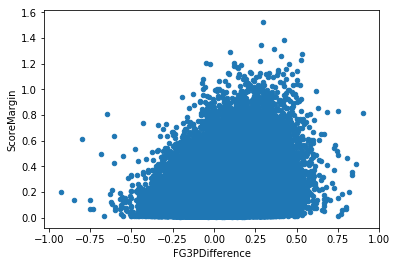

In [59]:
## Repeat the above for 3 point field goal performance

df_reg_detail_eda['WFG3P'] = df_reg_detail_eda.WFGM3 / df_reg_detail_eda.WFGA3 ## 3 point field goal percentage for the winning team
df_reg_detail_eda['LFG3P'] = df_reg_detail_eda.LFGM3 / df_reg_detail_eda.LFGA3 ## 3 point field goal percentage for the losing team
df_reg_detail_eda['FG3PDifference'] = (df_reg_detail_eda.WFG3P - df_reg_detail_eda.LFG3P) ## Difference in 3 point field goal percentage
df_reg_detail_eda.plot.scatter(x='FG3PDifference', y='ScoreMargin')


The correlation between 3 point field goal percentage difference and win margin is not too strong. This indicates that teams that win a game with a larger margin tend to have only slightly better 3 point field goal percentage than the losing team in that game.

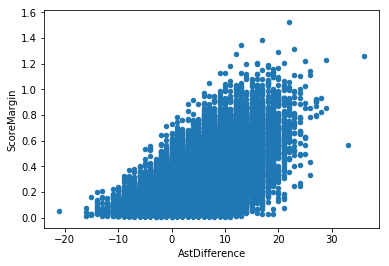

In [60]:
## Explore if the difference in assists between winning and losing teams correlate with win margin

df_reg_detail_eda['AstDifference'] = (df_reg_detail_eda.WAst - df_reg_detail_eda.LAst) ## Difference in assists between winner and loser of a game
df_reg_detail_eda.plot.scatter(x='AstDifference', y='ScoreMargin')

Relative performance in assists has a strong correlation with win margin. Assists indicate a more orchestrated style of play and may be an indicator how a team collaborates and creates opportunities on the field.

## Feature Engineering

Operationalize the notion of Point Opportunities Developed (POD) and Opportunity Convertion Rate (OCR).

In [16]:
## Add a few more columns 
## Now have a total of 44 columns

df_reg_detail['WPOD'] = df_reg_detail.WFGA3 * 3 + (df_reg_detail.WFGA - df_reg_detail.WFGA3) * 2 + df_reg_detail.WFTA * 1
df_reg_detail['LPOD'] = df_reg_detail.LFGA3 * 3 + (df_reg_detail.LFGA - df_reg_detail.LFGA3) * 2 + df_reg_detail.LFTA * 1

df_reg_detail['WOCR'] = 1.0 * df_reg_detail.WScore / df_reg_detail.WPOD
df_reg_detail['LOCR'] = 1.0 * df_reg_detail.LScore / df_reg_detail.LPOD

df_reg_detail['WFGP'] = df_reg_detail.WFGM / df_reg_detail.WFGA ## Field goal percentage for the winning team
df_reg_detail['LFGP'] = df_reg_detail.LFGM / df_reg_detail.LFGA ## Field goal percentage for the losing team

df_reg_detail['WFTP'] = df_reg_detail.WFTM / df_reg_detail.WFTA ## Field goal percentage for the winning team
df_reg_detail['LFTP'] = df_reg_detail.LFTM / df_reg_detail.LFTA ## Field goal percentage for the losing team

Next, we will calculate each team's performance on given field statistics for each season. Then, we will compare it to the overall performance of their league (again for each season) and then de-mean and re-scale the performance of teams by league and season. Lastly, we bin performance to dampen small variations.

In [17]:
# features of interest to aggregate
features_todo = ['FGP','FTP','FGA','FTA','Ast','Blk','OR','DR','POD','OCR','Stl']

In [18]:
# take in string of feature name
def calc_feats(dat,feat_list):
    
    # get just the list of teams, to build our features from
    w_cols = dat[[col for col in dat if col.startswith('W')]].copy()
    w_cols.columns = [s[1:] for s in w_cols.columns]
    w_cols['Season'] = dat['Season']
    
    l_cols = dat[[col for col in dat if col.startswith('L')]].copy()
    l_cols.columns = [s[1:] for s in l_cols.columns]
    l_cols['Season'] = dat['Season']
    
    # this is a dataframe with all games for each season, with relevant stats for each team on a row
    all_teams = pd.concat([w_cols,l_cols])
    
    all_tm_lg_szn = all_teams[['TeamID','LeagueName','Season']].drop_duplicates()
    
    for f in feat_list:
        # aggregate data
        team_agg = all_teams.groupby(['Season', 'LeagueName', 'TeamID'], as_index=False).agg({f:['mean']})
        team_agg.columns = team_agg.columns.droplevel(1)

        league_agg = all_teams.groupby(['Season', 'LeagueName'], as_index=False).agg({f:['mean','std']})
        league_agg.columns = [''.join(col).strip() for col in league_agg.columns.values]
        
        team_agg = pd.merge(left=team_agg,right=league_agg,how='left',on=['Season','LeagueName'])
        
        team_agg[f+'norm'] = ((team_agg[f] - team_agg[f+'mean'])/ team_agg[f+'std'])
        team_agg[f+'bin'] = pd.cut(team_agg[f+'norm'], 24, labels=False)
        
        all_tm_lg_szn = pd.merge(left=all_tm_lg_szn,right=team_agg,how='left',on=['Season','LeagueName','TeamID'])
            
    return all_tm_lg_szn  

Merge the calculated aggregate information about each performance statistic with the dataframe of teams and league information. This is now our go-to resource for team-level information that will be used going forward. 

In [19]:
# note: this includes teams from 2018
df_engineered_features = calc_feats(df_reg_detail,features_todo)
df_engineered_features = pd.merge(left=df_engineered_features,right=df_team_league_perf,how='left',on='TeamID')

In [20]:
df_engineered_features.head()

,TeamID,LeagueName,Season,FGP,FGPmean,FGPstd,FGPnorm,FGPbin,FTP,FTPmean,...,OCRmean,OCRstd,OCRnorm,OCRbin,Stl,Stlmean,Stlstd,Stlnorm,Stlbin,Leaguebin
0,3103,MAC,2010,0.405346,0.402665,0.072138,0.037166,10,0.704329,0.698111,...,0.432482,0.068308,0.104973,11,8.033333,9.304709,3.193953,-0.398057,5,2.0
1,3104,SEC,2010,0.400770,0.415768,0.074202,-0.202128,8,0.621109,0.676910,...,0.437030,0.071290,-0.327385,7,7.379310,8.371495,3.859940,-0.257047,6,23.0
2,3110,Patriot,2010,0.399550,0.381652,0.067985,0.263277,12,0.740438,0.686326,...,0.410244,0.065445,0.343623,14,7.952381,7.600000,3.381968,0.104194,9,0.0
3,3111,Sun Belt,2010,0.435525,0.394316,0.076786,0.536670,14,0.622631,0.671585,...,0.422639,0.073208,0.376765,14,9.935484,8.425287,3.595169,0.420063,11,1.0
4,3119,Patriot,2010,0.358097,0.381652,0.067985,-0.346465,7,0.673364,0.686326,...,0.410244,0.065445,-0.471252,6,6.458333,7.600000,3.381968,-0.337575,5,0.0


Now we create 'winning'/'team 1' and 'losing'/'team 2' versions of the engineered features dataframe. This makes it easier to merge in later parts of the project. We will only use the binned values of each performance measure. 

In [21]:
# Create 'winning team' and 'losing team' versions of engineered features DF

df_engineered_features_w = df_engineered_features[[col for col in df_engineered_features if col.endswith('bin')]].copy()
df_engineered_features_w.columns = map(lambda x:'1'+x,df_engineered_features_w.columns)
df_engineered_features_w['Season'] = df_engineered_features['Season']
df_engineered_features_w['1TeamID'] = df_engineered_features['TeamID']

df_engineered_features_l = df_engineered_features[[col for col in df_engineered_features if col.endswith('bin')]].copy()
df_engineered_features_l.columns = map(lambda x:'2'+x,df_engineered_features_l.columns)
df_engineered_features_l['Season'] = df_engineered_features['Season']
df_engineered_features_l['2TeamID'] = df_engineered_features['TeamID']

In [52]:
(df_engineered_features_l.columns)

Index(['FGPbin', 'FTPbin', 'FGAbin', 'FTAbin', 'Astbin', 'Blkbin', 'ORbin',
       'DRbin', 'PODbin', 'OCRbin', 'Stlbin', 'Leaguebin', 'Season', 'TeamID',
       'Outcome'],
      dtype='object')

## Build Regular Season and Tournament Datasets

Currently, our training dataset only includes 'positive' examples where  the first team is the winner. So, we will generate opposite examples to remove bias in our training data.

In [22]:
# This function can be used to reverse winning and losing teams
# to make datapoints with Result = 0
def gen_neg_items(df):
    df_wins = pd.DataFrame()
    df_wins['Season'] = df['Season']
    df_wins['1TeamID'] = df['WTeamID']
    df_wins['2TeamID'] = df['LTeamID']
    df_wins['Result'] = 1

    df_losses = pd.DataFrame()
    df_losses['Season'] = df['Season']
    df_losses['1TeamID'] = df['LTeamID']
    df_losses['2TeamID'] = df['WTeamID']
    df_losses['Result'] = 0
    
    return pd.concat((df_wins, df_losses))

We are only interested in games that were played in 2010-present because those are the games that we have detailed performance measures for, and those are what we use to calculate the binned measures above.


In [24]:
# get games from 2010-present
df_regular_season_games = gen_neg_items(df_reg_detail[df_reg_detail['Season'] > 2009])

In [26]:
# add engineered features to the detailed results
df_regular_season_games_with_features = pd.merge(left=df_regular_season_games, right=df_engineered_features_w, on=['Season', '1TeamID'])
df_regular_season_games_with_features = pd.merge(left=df_regular_season_games_with_features, right=df_engineered_features_l, on=['Season', '2TeamID'])

At this point, we now have the training set for model 1, which is only used for further feature engineering for our final predictions. It contains all matchups from regular season games 2010-17, plus 2018. This will be separated out for training, as we will predict 2018 games, but it is easiest to include for the sake of calculating these measures. Note that each game appears twice, to reflect both permutations of team matchups. 

In [27]:
# This is the training dataset for model 1
# Contains all matchups from regular season games 2010-18
# These are duplicated for both 'win' and 'loss' outcomes 
df_regular_season_games_with_features.head()

,Season,1TeamID,2TeamID,Result,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,...,2FGAbin,2FTAbin,2Astbin,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin
0,2010,3103,3237,1,10,14,7,12,10,6,...,5,14,2,15,12,11,5,6,7,4.0
1,2010,3231,3237,1,6,12,14,14,6,2,...,5,14,2,15,12,11,5,6,7,4.0
2,2010,3282,3237,1,12,14,10,11,10,7,...,5,14,2,15,12,11,5,6,7,4.0
3,2010,3282,3237,1,12,14,10,11,10,7,...,5,14,2,15,12,11,5,6,7,4.0
4,2010,3293,3237,1,12,19,13,12,12,13,...,5,14,2,15,12,11,5,6,7,4.0


While we're at it, let's build our dataset for generating features for our second (actual) model. It will contain all actual tournament data from 2010-18. 

In [30]:
# This is all actual tournament data from 2010-18

# Key difference: 2010-17 tourneys by win-lose team
# 2018 is organized by team #

df_tour = df_tour_detail[df_tour_detail['Season'] > 2009]
df_tour = df_tour[['Season', 'WTeamID', 'LTeamID']]

# this now also includes 0 outcome items
df_tour = gen_neg_items(df_tour)
df_tour.shape

(1008, 4)

In [32]:
df_tour_18 = df_tour_18.rename(columns={'Team1':'1TeamID', 'Team2':'2TeamID'})

df_tour_matchups = pd.concat([df_tour, df_tour_18], ignore_index=False)
df_tour_matchups.shape # 63 games longer than other

(1071, 4)

In [33]:
# Inject regular season stats to tournament games
df_tour_matchups_with_features = pd.merge(left=df_tour_matchups, right=df_engineered_features_w, on=['Season', '1TeamID'])
df_tour_matchups_with_features = pd.merge(left=df_tour_matchups_with_features, right=df_engineered_features_l, on=['Season', '2TeamID'])

## Train Model 1 on Regular Season Results

Model 1 is really just used for feature engineering. We have explored various ways to reflect a team's regular season 'performance', and determined that predicting an outcome based on these field performance measures (given, or engineered above) produces the best result. So we will train on 2010-17 data, and then later test on 2018 to gather probabilities that a given matchup ends in success.  

In [35]:
# For 8 teams, we are missing league information so we've had to drop those from our dataset
df_train_1 = df_regular_season_games_with_features.dropna(how='any')

# Separate training and test data based on season played
# Will eventually be predicting 2018 matchups, so that must be test
X_train_1 = df_train_1[df_train_1['Season'] < 2018]
#X_test_1 = df_train_1[df_train_1['Season'] == 2018]

y_train_1 = X_train_1.Result.values
#y_test_1 = X_test_1.Result.values

# split data before 2018 to train and dev
X_train_1 = X_train_1.drop('Result', 1)
#X_test_1 = X_test_1.drop('Result', 1)

In [36]:
# this function can be used to evaluate our models
def eval(clf,train_x,train_y):
    clf.fit(train_x,train_y)
    acc = cross_val_score(clf, train_x, train_y, cv=5, scoring='accuracy')
    print 'Average Accuracy by CV = {}, vals = {}'.format(np.mean(acc), acc)
    
    logloss = cross_val_score(clf, train_x, train_y, cv=5, scoring='neg_log_loss')
    print 'Average Log Loss by CV = {}, vals = {}'.format(-np.mean(logloss), -logloss)

The evaluation aspect of this part is interesting, but we are not trying to optimize log loss at this point. Rather, we are selecting the best model for engineering our 'WinProb' feature in the second model.

In [37]:
print ('fitting logistic regression model')
modelLR = LogisticRegression()
eval(modelLR,X_train_1,y_train_1)

print ('\nfitting Naive Bayes model')
modelNB = GaussianNB()
eval(modelNB,X_train_1,y_train_1)

print ('\nfitting Random Forest model')
modelRF = RandomForestClassifier(n_jobs=2, random_state=0)
eval(modelRF,X_train_1,y_train_1)

fitting logistic regression model
Average Accuracy by CV = 0.728267715089, vals = [ 0.73046495  0.71665044  0.72316212  0.73332522  0.73773585]
Average Log Loss by CV = 0.527175557838, vals = [ 0.52984772  0.53735087  0.53128054  0.52140305  0.51599562]

fitting Naive Bayes model
Average Accuracy by CV = 0.690791099237, vals = [ 0.68263145  0.68944742  0.68719572  0.69632425  0.69835666]
Average Log Loss by CV = 0.73855879001, vals = [ 0.76781505  0.74201815  0.74620983  0.71053989  0.72621104]

fitting Random Forest model
Average Accuracy by CV = 0.68283060501, vals = [ 0.67642405  0.68159688  0.68591772  0.68896056  0.6812538 ]
Average Log Loss by CV = 0.717963412351, vals = [ 0.71422789  0.74294204  0.73021414  0.71653986  0.68589312]


## Engineer Feature 'winprob' for tournament matchups based on regular season data

Now we are ready to continue feature engineering for our final model. Here we will use the tournament data with engineered features to make predictions about the outcomes of these tournament games.

In [38]:
df_tour_matchups_with_features.head()

,Season,1TeamID,2TeamID,Result,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,...,2FGAbin,2FTAbin,2Astbin,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin
0,2010,3124,3201,1,14,16,8,20,11,18,...,14,14,12,6,12,13,15,13,12,7.0
1,2010,3124,3207,1,14,16,8,20,11,18,...,12,16,13,6,16,2,13,10,17,15.0
2,2010,3265,3207,0,15,22,10,15,13,13,...,12,16,13,6,16,2,13,10,17,15.0
3,2010,3124,3397,1,14,16,8,20,11,18,...,11,11,12,17,13,18,9,16,5,23.0
4,2010,3173,3397,0,13,14,15,16,13,14,...,11,11,12,17,13,18,9,16,5,23.0


In [39]:
# Need to make predictions for everything in tournament data
# Do not separate 2018 from everything else - need to generate predictions

X_train_2 = df_tour_matchups_with_features
y_train_2 = X_train_2.Result.values
X_train_2 = X_train_2.drop('Result', 1)

Use Naive Bayes Probabilities to determine win probability for the first team in the matchup. This reflects their past regular season performance, will combine with other features to strengthen tournament predictions.

In [42]:
# tournament win probability from predictions in model 1
df_tour_winprob = pd.DataFrame(modelNB.predict_proba(X_train_2), columns=['LossProb','WinProb'])

df_tour_winprob = pd.concat([X_train_2, df_tour_winprob],axis=1)

df_tour_winprob['Result'] = y_train_2
df_tour_winprob.tail()

,Season,1TeamID,2TeamID,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,1ORbin,...,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin,LossProb,WinProb,Result
1066,2018,3323,3437,19,18,14,16,17,7,13,...,13,7,15,9,10,2,15.0,0.000087,0.999913,1
1067,2018,3355,3437,13,18,12,15,14,13,14,...,13,7,15,9,10,2,15.0,0.016872,0.983128,0
1068,2018,3329,3393,9,17,13,18,9,4,12,...,7,13,10,15,8,9,22.0,0.448743,0.551257,1
1069,2018,3332,3370,17,17,10,14,15,10,10,...,9,13,21,13,12,7,0.0,0.021660,0.978340,1
1070,2018,3333,3443,16,13,8,6,15,17,10,...,13,19,6,14,14,15,12.0,0.168957,0.831043,1


## Feature Engineering & Selection for Model 2

Lastly, we will finalize feature engineering for our model. Since our baseline of just a seed difference feature performs rather well, we would like to include that. But the difference in seed doesn't seem to track with difference in performance as seed value grows, so we develop a % and then calculate the difference for each matchup. Also, as discussed, we will include the difference in league strength based on calculations above.

Our features for this model are 'WinProb' (predicted based on regular season performance), 'SeedDiffPct' (weighted seed difference based on seed values), and 'LeaguebinDiff' (difference in the relative league performance of each team).

In [44]:
# Get seeds for each team
df_seeds_w = df_seeds.rename(columns={'TeamID' : '1TeamID','SeedInt' : '1Seed'})
df_tour_final_feats = pd.merge(left=df_tour_winprob, right=df_seeds_w, how='left', on=['Season','1TeamID'])

df_seeds_l = df_seeds.rename(columns={'TeamID' : '2TeamID','SeedInt' : '2Seed'})
df_tour_final_feats = pd.merge(left=df_tour_final_feats, right=df_seeds_l, how='left', on=['Season','2TeamID'])

## Calculate 'difference' statistics for teams in the matchup

# positive seed difference indicate that Team1 is higher seed
df_tour_final_feats['SeedDiff'] = df_tour_final_feats['2Seed'] - df_tour_final_feats['1Seed']
df_tour_final_feats['SeedDiffPct'] = df_tour_final_feats['SeedDiff'] / (df_tour_final_feats['1Seed'] + df_tour_final_feats['2Seed'])

# We would also like to weight by relative league strength, so calculate that difference
df_tour_final_feats['LeaguebinDiff'] = df_tour_final_feats['1Leaguebin'] - df_tour_final_feats['2Leaguebin']

## this now contains all reg season features plus select 'difference' features
df_tour_final_feats.head()

,Season,1TeamID,2TeamID,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,1ORbin,...,2Stlbin,2Leaguebin,LossProb,WinProb,Result,1Seed,2Seed,SeedDiff,SeedDiffPct,LeaguebinDiff
0,2010,3124,3201,14,16,8,20,11,18,9,...,12,7.0,0.076033,0.923967,1,4,13,9,0.529412,14.0
1,2010,3124,3207,14,16,8,20,11,18,9,...,17,15.0,0.059654,0.940346,1,4,5,1,0.111111,6.0
2,2010,3265,3207,15,22,10,15,13,13,7,...,17,15.0,0.088892,0.911108,0,12,5,-7,-0.411765,-12.0
3,2010,3124,3397,14,16,8,20,11,18,9,...,5,23.0,0.438670,0.561330,1,4,1,-3,-0.600000,-2.0
4,2010,3173,3397,13,14,15,16,13,14,16,...,5,23.0,0.642625,0.357375,0,8,1,-7,-0.777778,-13.0


In [49]:
# Generate features for baseline data

X_train_baseline = df_tour_final_feats[['SeedDiff']][df_tour_final_feats['Season'] < 2018]
X_test_baseline = df_tour_final_feats[['SeedDiff']][df_tour_final_feats['Season'] == 2018]

# Output = 1 or 0
y_train_baseline = df_tour_final_feats[df_tour_final_feats['Season'] < 2018]['Result']
y_test_baseline = df_tour_final_feats[df_tour_final_feats['Season'] == 2018]['Result']

In [50]:
# Final features: SeedDiffPct, LeaguebinDiff, winprob
X_train = df_tour_final_feats[['SeedDiffPct','LeaguebinDiff','WinProb']][df_tour_final_feats['Season'] < 2018]
X_test = df_tour_final_feats[['SeedDiffPct','LeaguebinDiff','WinProb']][df_tour_final_feats['Season'] == 2018]

# Output = 1 or 0
y_train = df_tour_final_feats[df_tour_final_feats['Season'] < 2018]['Result']
y_test = df_tour_final_feats[df_tour_final_feats['Season'] == 2018]['Result']

## Fit Model 2 to Training Tourney Matchups and Predict Test Matchups

In [51]:
# Determine models we'd like to use
model_names = ['Logistic Regression', 'SVM', 'Gaussian NB', 'Random Forests', 'Gradient Boosting']
models = [LogisticRegression(),svm.SVC(probability=True),GaussianNB(),RandomForestClassifier(n_jobs=2, random_state=0),GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=2, random_state=0)]

In [52]:
## Reminder of baseline predictions

#????Since we have baseline comparisom in the evaluation, do we need to keep this????

for i, val in enumerate(models):
    model = val
    print ('\nPerformance on '+model_names[i])
    eval(model,X_train_baseline,y_train_baseline)
    print 


Performance on Logistic Regression
Average Accuracy by CV = 0.780722772277, vals = [ 0.77722772  0.78712871  0.7970297   0.77722772  0.765     ]
Average Log Loss by CV = 0.45727395627, vals = [ 0.46095316  0.45891937  0.45084004  0.44146887  0.47418835]


Performance on SVM
Average Accuracy by CV = 0.778742574257, vals = [ 0.77722772  0.78217822  0.79207921  0.77722772  0.765     ]
Average Log Loss by CV = 0.526177259238, vals = [ 0.52796168  0.52064082  0.51057314  0.52619355  0.5455171 ]


Performance on Gaussian NB
Average Accuracy by CV = 0.780722772277, vals = [ 0.77722772  0.78712871  0.7970297   0.77722772  0.765     ]
Average Log Loss by CV = 0.457358657284, vals = [ 0.46123407  0.45847286  0.45085999  0.44131294  0.47491343]


Performance on Random Forests
Average Accuracy by CV = 0.778742574257, vals = [ 0.77722772  0.78217822  0.79207921  0.77722772  0.765     ]
Average Log Loss by CV = 0.545406552857, vals = [ 0.59613746  0.76027311  0.429262    0.43727333  0.50408686]


P

In [53]:
## Achieve better results using our model

for i, val in enumerate(models):
    model = val
    print ("\nPerformance on "+ model_names[i])
    eval(model,X_train,y_train)
    print


Performance on Logistic Regression
Average Accuracy by CV = 0.781782178218, vals = [ 0.74257426  0.78217822  0.78712871  0.7970297   0.8       ]
Average Log Loss by CV = 0.442330666271, vals = [ 0.45388622  0.43398474  0.42628488  0.43192258  0.46557491]


Performance on SVM
Average Accuracy by CV = 0.770841584158, vals = [ 0.76732673  0.77722772  0.76237624  0.77227723  0.775     ]
Average Log Loss by CV = 0.489091627994, vals = [ 0.50599174  0.47831128  0.48578479  0.48667977  0.48869056]


Performance on Gaussian NB
Average Accuracy by CV = 0.785742574257, vals = [ 0.75247525  0.7970297   0.78217822  0.7970297   0.8       ]
Average Log Loss by CV = 0.490955374965, vals = [ 0.52010524  0.45744382  0.47485313  0.47388918  0.52848551]


Performance on Random Forests
Average Accuracy by CV = 0.757930693069, vals = [ 0.77227723  0.75742574  0.73762376  0.76732673  0.755     ]
Average Log Loss by CV = 1.30782240127, vals = [ 1.29252658  1.25506192  1.60825097  1.11402124  1.2692513 ]


P

Logistic Regression performs the best in either baseline and final model. Then we fit the baseline model and the optimal logistic regression model for the evaluation and test compared to Kaggle competition.

In [54]:
#Fit the baseline LogisticRegression Model for comparisom 
logreg_bl = LogisticRegression()
logreg_bl.fit(X_train_baseline,y_train_baseline)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
#Fit the LogisticRegression Model
C=list(np.power(10.0, np.arange(-10, 10)))

searchCV = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='neg_log_loss'
        ,cv=5
        ,random_state=777
        ,max_iter=1000
        ,fit_intercept=True
        ,solver='lbfgs'
        ,tol=10
    )
searchCV.fit(X_train,y_train)
max_neg_log_loss = searchCV.scores_[1].max()
#searchCV.coef_
print ('Negative log loss:', (max_neg_log_loss))
print("The Best C value is :",C[np.argwhere(searchCV.scores_[1]==max_neg_log_loss)[0][1]])

#print(type(list(np.power(10.0, np.arange(-10, 10)))))




('Negative log loss:', -0.42687337050117302)
('The Best C value is :', 1.0)


In [58]:
#get the intercept and coefficients of features
print 'intercept:', searchCV.intercept_ 
print '\ncoefficients:', searchCV.coef_
print '\nfeatures:', list(X_train.columns.values)
logreg = searchCV

intercept: [-0.76172847]

coefficients: [[ 2.04437759  0.06123573  1.53355505]]

features: ['SeedDiffPct', 'LeaguebinDiff', 'WinProb']


So our optimal model's logistic regression formula is below:

$$
logit(p) = ln(\frac{p}{1-p}) = -0.762 + 2.044\cdot SeedDiffPct + 0.061\cdot LeaguebinDiff + 1.534\cdot WinProb
$$

## Evaluation

- We finally choose our optimal model as the logistic regression model with aggregated features 'SeedDiffPct', 'LeaguebinDiff', 'WinProb'.
- In the evaluation session, we first compared the performances of optimal model with that of our orginal baseline, with cross validation of training data. Then, we used our optimal model to predict the winning prob of 2018 tournament and got the log loss score to compared with Kaggle leaderboard ranking. 

### Log Loss

- Log Loss is the most important classification metric based on probabilities. It is also a key way of evaluation of our prediction from Kaggle NCAA page. 
- It is also called the Log Likelihood Function. The log of the likelihood that the 2018 tournament bracket actually happens based on our prediction of wining probability of each team matchups.

$$
LogLoss = \sum_{i=1}^{n} [y_i log(\hat{y_i})+(1-y_i) log(1-\hat{y_i})]
$$

- The result will be a negative number that's in a range computers keep track of. However, Scikit-learn has a conventin in its metrics that lower scores are better. 
    - So, scikit-learn report 
    
    $$-1* \frac{LogLoss}{NumObservations}$$
    
    $$
    LogLoss = -\frac{1}{n} \sum_{i=1}^{n} [y_i log(\hat{y_i})+(1-y_i) log(1-\hat{y_i})]
    $$
    
    - The division by the number of datapoints is used so the range of values doesn't systematically vary with the dataset size. 
    - The rage of that is 0 to infinit. 
    - The lower the metrix is, the better model performance is.
    
- Log loss penalizes both types of errors, but especially those predications that are confident and wrong.

In [60]:
#log loss with cross validation
logloss_logreg_bl = cross_val_score(logreg_bl, X_train_baseline, y_train_baseline, cv=5, scoring='neg_log_loss')
logloss_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='neg_log_loss')

print 'Log Loss of baseline model = {}, vals = {}'.format(-np.mean(logloss_logreg_bl), -logloss_logreg_bl)
print 'Log Loss of optimal model = {}, vals = {}'.format(-np.mean(logloss_logreg), -logloss_logreg)

Log Loss of baseline model = 0.45727395627, vals = [ 0.46095316  0.45891937  0.45084004  0.44146887  0.47418835]
Log Loss of optimal model = 0.442280513175, vals = [ 0.45521022  0.43390128  0.42740666  0.43096635  0.46391806]


The Log Loss value of optimal model is 0.44228, which is a very good outcome, better than the baseline model by 0.015. 

### Accuracy

Accuracy measures a fraction of the classifier's predictions that are correct.

In [63]:
# Accuracy with cross validation
acc_logreg_bl = cross_val_score(logreg_bl, X_train_baseline, y_train_baseline, cv=5, scoring='accuracy')
acc_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')

print 'Accuracy of baseline model = {}, vals = {}'.format(np.mean(acc_logreg_bl), acc_logreg_bl)
print 'Accuracy of optimal model = {}, vals = {}'.format(np.mean(acc_logreg), acc_logreg)

Accuracy of baseline model = 0.780722772277, vals = [ 0.77722772  0.78712871  0.7970297   0.77722772  0.765     ]
Accuracy of optimal model = 0.781782178218, vals = [ 0.74257426  0.78217822  0.79207921  0.79207921  0.8       ]


The accuracy score of optimal model is 0.78178, higher than baseline model by 0.001.

### F1 measure

- **Precision** is the fraction of positive predictions that are correct, which means the team who we predicts as winner that are actually winner. 
    - (TP = True Positive, FP = False Positive)

$$ P = \frac{TP}{TP+FP}$$


- **Recall**, the true positive rate, is the fraction of the truly positive instances that the classifier recognizes. A recall score of one indicates that the classifier did not make any false negative predictions.
In our case, recall is the fraction of winner team that were truly classified as winner, according to our prediction of winning proberbility. 
    - (TP = True Positive, FN = False Negative)
    
$$ P = \frac{TP}{TP+FN}$$

In [65]:
# precisions and recalls with cross validation
precisions_logreg_bl = cross_val_score(logreg_bl, X_train_baseline, y_train_baseline, cv=5, scoring='precision')
print 'Precision of baseline model = {}, vals = {}'.format(np.mean(precisions_logreg_bl), precisions_logreg_bl)
precisions_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='precision')
print 'Precision of optimal model = {}, vals = {}'.format(np.mean(precisions_logreg), precisions_logreg)

recalls_logreg_bl = cross_val_score(logreg_bl, X_train_baseline, y_train_baseline, cv=5, scoring='recall')
print '\nRecalls of baseline model = {}, vals = {}'.format(np.mean(recalls_logreg_bl), recalls_logreg_bl)
recalls_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='recall')
print 'Recalls of optimal model = {}, vals = {}'.format(np.mean(recalls_logreg), recalls_logreg)

Precision of baseline model = 0.780065459319, vals = [ 0.78571429  0.76363636  0.81914894  0.76415094  0.76767677]
Precision of optimal model = 0.781172696078, vals = [ 0.74257426  0.76635514  0.81052632  0.78640777  0.8       ]

Recalls of baseline model = 0.783683168317, vals = [ 0.76237624  0.83168317  0.76237624  0.8019802   0.76      ]
Recalls of optimal model = 0.783762376238, vals = [ 0.74257426  0.81188119  0.76237624  0.8019802   0.8       ]


- The **F1 measure** is the harmonic mean, or weighted average, of the precision and recall scores. Also called the f-measure or the f-score. 
    - (P = precision, R = recall) 
    $$ F1 = 2 \frac{PR}{P+R}$$

    
- The F1 measure penalizes classifiers with imbalanced precision and recall scores, like the trivial classifier that always predicts the positive class. 
- A model with perfect precision and recall scores will achieve an F1 score of 1. A model with a perfect precision score and a recall score of zero will achieve an F1 score of 0.
- Models are sometimes evaluated using the F0.5 and F2 scores, which favor precision over recall and recall over precision, respectively.

In [66]:
#F1 score with cross validation
f1s_logreg_bl = cross_val_score(logreg_bl, X_train_baseline, y_train_baseline, cv=5, scoring='f1')
print 'F1 of baseline model = {}, vals = {}'.format(np.mean(f1s_logreg_bl), f1s_logreg_bl)

f1s_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='f1')
print 'F1 of optimal model = {}, vals = {}'.format(np.mean(f1s_logreg), f1s_logreg)

F1 of baseline model = 0.781249851683, vals = [ 0.77386935  0.79620853  0.78974359  0.7826087   0.7638191 ]
F1 of optimal model = 0.782173545732, vals = [ 0.74257426  0.78846154  0.78571429  0.79411765  0.8       ]


For the optimal model, the arithmetic mean of our classifier's precision and recall scores is 0.7821, slightly higher than that of baseline model, 0.7812. For both model, the F1 scores are high, indicating that the F1 measure's penalty is small. 

### ROC Curve

- Receiver Operating Characteristic, or ROC curve, visualizes a classifier's performance.
- ROC curve illustrates the classifier's performance for all values of the discrimination threshold. 
    - The true positive rate (Sensitivity, Recall ) is plotted in function of the false positive rate (100-Specificity, Fall-out) for different cut-off points. 
    - Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. 
- AUC is the area under the ROC curve; it reduces the ROC curve to a single value, which represents the expected performance of the classifier. 
- The dashed line in the following figure is for a classifier that predicts classes randomly; it has an AUC of 0.5. The solid curve is for a classifier that outperforms random guessing.
- A test with perfect discrimination (no overlap in the two distributions) has a ROC curve that passes through the upper left corner (100% sensitivity, 100% specificity). Therefore the closer the ROC curve is to the upper left corner, the higher the overall accuracy of the test (Zweig & Campbell, 1993)

https://www.medcalc.org/manual/roc-curves.php

In [67]:
from scipy import interp
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

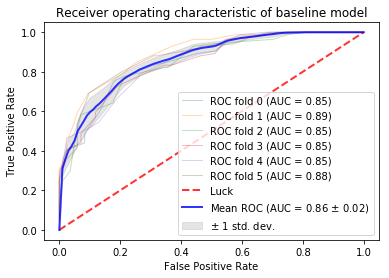

In [68]:
#plot the ROC curve with cross validation for baseline model
X_bl = np.array(X_train_baseline)
y_bl = np.array(y_train_baseline)

n_samples_bl, n_features_bl = X_bl.shape

# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv_bl = StratifiedKFold(n_splits=6)
classifier_bl = logreg_bl

tprs_bl = []
aucs_bl = []
mean_fpr_bl = np.linspace(0, 1, 100)

i = 0
for train, test in cv_bl.split(X_bl, y_bl):
    probas__bl = classifier_bl.fit(X_bl[train], y_bl[train]).predict_proba(X_bl[test])
    # Compute ROC curve and area the curve
    fpr_bl, tpr_bl, thresholds_bl = roc_curve(y_bl[test], probas__bl[:, 1])
    tprs_bl.append(interp(mean_fpr_bl, fpr_bl, tpr_bl))
    tprs_bl[-1][0] = 0.0
    roc_auc_bl = auc(fpr_bl, tpr_bl)
    aucs_bl.append(roc_auc_bl)
    plt.plot(fpr_bl, tpr_bl, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc_bl))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr_bl = np.mean(tprs_bl, axis=0)
mean_tpr_bl[-1] = 1.0
mean_auc_bl = auc(mean_fpr_bl, mean_tpr_bl)
std_auc_bl = np.std(aucs_bl)
plt.plot(mean_fpr_bl, mean_tpr_bl, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_bl, std_auc_bl),
         lw=2, alpha=.8)

std_tpr_bl = np.std(tprs_bl, axis=0)
tprs_upper_bl = np.minimum(mean_tpr_bl + std_tpr_bl, 1)
tprs_lower_bl = np.maximum(mean_tpr_bl - std_tpr_bl, 0)
plt.fill_between(mean_fpr_bl, tprs_lower_bl, tprs_upper_bl, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of baseline model')
plt.legend(loc="lower right")
plt.show()

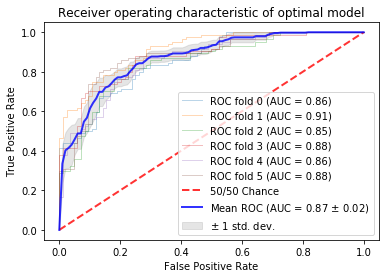

In [69]:
#plot the ROC curve with cross validation for optimal model
X = np.array(X_train)
y = np.array(y_train)

n_samples, n_features = X.shape

# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = logreg

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='50/50 Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of optimal model')
plt.legend(loc="lower right")
plt.show()

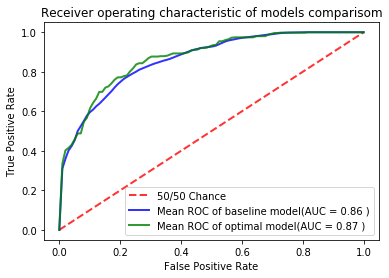

In [70]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='50/50 Chance', alpha=.8)

mean_tpr_bl = np.mean(tprs_bl, axis=0)
mean_tpr_bl[-1] = 1.0
mean_auc_bl = auc(mean_fpr_bl, mean_tpr_bl)
std_auc_bl = np.std(aucs_bl)
plt.plot(mean_fpr_bl, mean_tpr_bl, color='b',
         label=r'Mean ROC of baseline model(AUC = %0.2f )' % (mean_auc_bl),
         lw=2, alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='g',
         label=r'Mean ROC of optimal model(AUC = %0.2f )' % (mean_auc),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of models comparisom')
plt.legend(loc="lower right")
plt.show()

- Both of the ROC curves are on the upper left corner, indicating a good discrimination. The average AUC value from cross validation of optimal model is 0.87, higher than that of baseline model, which is 0.86. Hence, the expected performance of the optimal model is better than baseline model. 


- The ROC curve of the optimal model is slightly deeper at the beginning than that of baseline model. Kaggle punishs the prediction that something is true when it is actually false, the false positive prediction, which means we are looking for less false positive rate. So, the optimal model performs better, under the rule of Kaggle (https://www.kaggle.com/c/womens-machine-learning-competition-2018#evaluation)

### Summary

After checking Log Loss, Accuracy, Precision and recall, F1 measure, and ROC Curve with cross validation of training data, the optimal model performs better in all measurements: 
- Higher accuracy and F1 score; 
- less false positive rate and higher AUC in ROC curve; 
- and most importantly, smaller log loss score. 

# Deployment

### Log Loss on 2018 Tournament Result

After evaluate the models and make decision on our optimal model, we predicted the winning probabilities of 2018 tournament results for every possible matchup of teams, and compare the predicted outcomes for matchups that actually happened with the 2018 tournament result and generate a log loss score to compare with the leaderboard in Kaggle. 

In [72]:
#Create the each team matchups ID for submission file
X_test_baseline_with_ID = df_tour_final_feats[['SeedDiff','1TeamID','2TeamID','Season']][df_tour_final_feats['Season'] == 2018]
X_test_baseline_with_ID['ID'] = X_test_baseline_with_ID.apply(lambda row: str(int(row['Season']))+'_'+ \
                                            str(int(row['1TeamID']))+'_'+ \
                                            str(int(row['2TeamID'])), axis=1) 
X_test_with_ID = df_tour_final_feats[['Season','1TeamID','2TeamID','SeedDiffPct','LeaguebinDiff','WinProb']]\
                    [df_tour_final_feats['Season'] == 2018]
X_test_with_ID['ID'] = X_test_with_ID.apply(lambda row: str(int(row['Season']))+'_'+ \
                                            str(int(row['1TeamID']))+'_'+ \
                                            str(int(row['2TeamID'])), axis=1) 

In [73]:
#Create the final prediction data frame and output the subission csv file
df_sub = pd.DataFrame(data=X_test_with_ID['ID'],columns=['ID'])
pred_sub = searchCV.predict_proba(X_test)
df_sub['Pred']=pred_sub[:,1]
df_sub.to_csv('NCAA_Pred_2018.csv', index=False)

#create the final test dataframe
#df_sub = pd.read_csv('NCAA_Pred_2018.csv')
df_result = pd.read_csv('NCAA_Result_2018.csv')
df_eval = df_result.merge(df_sub, left_on='ID', right_on='ID', how='left')
df_eval.head()

,ID,Result,Pred
0,2018_3163_3384,1,0.959154
1,2018_3274_3346,0,0.615477
2,2018_3125_3181,0,0.208890
3,2018_3208_3273,1,0.837981
4,2018_3138_3378,1,0.413795


In [94]:
y_pred = df_eval.loc[:,'Pred'].as_matrix()
y_true = df_eval.loc[:,'Result'].as_matrix()

y_pred_bin = y_pred > .5
y_pred_bin = [x*1 for x in y_pred_bin]

print 'Log Loss of 2018 Tournament Result:', log_loss(y_true, y_pred, eps=1e-15)
print 'Accuracy of 2018 Tournament Result:',  accuracy_score(y_true, y_pred_bin)

Log Loss of 2018 Tournament Result: 0.431590444807
Accuracy of 2018 Tournament Result: 0.761904761905


The log loss score for optimal model is 0.43159, which is a great outcome. The Log Loss score follows the evaluation criteria of Kaggle competition, we would be placed in the rank of 16 from 505 teams. Accuracy is 0.7619, which is also relatively high. 